# Spectral fitting example (4C+21.35, noflare)


**To run this, you need the following files, which can be downloaded using the first few cells of this notebook:**
- orientation file (COSI-SMEX/DC3/Data/Orientation/DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori)       
- download unbinned data (COSI-SMEX/DC3/Data/Sources/4C21p35_flare_3months_unbinned_data_filtered_with_SAAcut.fits.gz, COSI-SMEX/DC3/Data/Sources/4C21p35_noflare_3months_unbinned_data_filtered_with_SAAcut.fits.gz, COSI-SMEX/DC3/Data/Backgrounds/Ge/AlbedoPhotons_3months_unbinned_data_filtered_with_SAAcut.fits.gz), combine with background and binning     
- detector response (COSI-SMEX/DC3/Data/Responses/ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5.zip)     

**The binned data are simulations of the 4C+21.35 (noflare) and albedo photon background produced using the COSI SMEX mass model. The detector response needs to be unzipped before running the notebook.**

This notebook fits the spectrum of a 4C+21.35 (noflare) simulated using MEGAlib and combined with background.

[3ML](https://threeml.readthedocs.io/) is a high-level interface that allows multiple datasets from different instruments to be used coherently to fit the parameters of source model. A source model typically consists of a list of sources with parametrized spectral shapes, sky locations and, for extended sources, shape. Polarization is also possible. A "coherent" analysis, in this context, means that the source model parameters are fitted using all available datasets simultanously, rather than performing individual fits and finding a well-suited common model a posteriori. 

In order for a dataset to be included in 3ML, each instrument needs to provide a "plugin". Each plugin is responsible for reading the data, convolving the source model (provided by 3ML) with the instrument response, and returning a likelihood. In our case, we'll compute a binned Poisson likelihood:

$$
\log \mathcal{L}(\mathbf{x}) = \sum_i \log \frac{\lambda_i(\mathbf{x})^{d_i} \exp (-\lambda_i)}{d_i!}
$$

where $d_i$ are the counts on each bin and $\lambda_i$ are the expected counts given a source model with parameters $\mathbf{x}$. 

In this example, we will fit a single point source with a known location. We'll assume the background is known and fixed up to a scaling factor. Finally, we will fit a Powerlaw function:

$$
f(x) = K \left(\frac{x}{E_{piv}}\right)^{\alpha}
$$

where $K$ (normalization), $\alpha$ (spectral index), are the free parameters, while $E_{piv}$ is the pivot energy which is fixed (and arbitrary).

Considering these assumptions:

$$
\lambda_i(\mathbf{x}) = B*b_i + s_i(\mathbf{x})
$$

where $B*b_i$ are the estimated counts due to background in each bin with $B$ the amplitude and $b_i$ the shape of the background, and $s_i$ are the corresponding expected counts from the source, the goal is then to find the values of $\mathbf{x} = [K, \alpha]$ and $B$ that maximize $\mathcal{L}$. These are the best estimations of the parameters.

The final module needs to also fit the time-dependent background, handle multiple point-like and extended sources, as well as all the spectral models supported by 3ML. Eventually, it will also fit the polarization angle. However, this simple example already contains all the necessary pieces to do a fit.

In [1]:
from cosipy import COSILike, BinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.response.FullDetectorResponse import FullDetectorResponse
from cosipy.util import fetch_wasabi_file

from scoords import SpacecraftFrame

from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import poisson_conf_interval

import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

from threeML import Band, PointSource, Model, JointLikelihood, DataList
from cosipy import Band_Eflux
from astromodels import Parameter

from pathlib import Path

import os
import corner
from threeML import*
from astromodels import *


08:17:14 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=544156;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=490484;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#47\47]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=236441;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=411520;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#68\68]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=359497;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=992538;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

         INFO      Starting 3ML!                                                                     ]8;id=942449;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=934278;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#39\39]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=416415;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=138419;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=189464;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=34136;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#41\41]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=577798;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=666068;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#44\44]8;;\

08:17:14 WARNING   ROOT minimizer not available                                                ]8;id=776031;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=880069;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=428819;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=421249;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=165627;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=715051;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=728620;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=382909;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=867971;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=86322;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=84488;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=506950;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

08:17:15 WARNING   No fermitools installed                                              ]8;id=257903;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=433515;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

08:17:15 WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=134314;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=889254;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=427934;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=157436;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=546417;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=338807;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

## Get the data

Define the path to the directory to save the data. The data can be downloaded by running the cells below. Each respective cell also gives the wasabi file path and file size.

In [2]:
data_path = Path("/home/srinadb/cosipy/docs/tutorials/spectral_fits/dataset/")

Download the orientation file (684.38 MB)

In [3]:
fetch_wasabi_file('COSI-SMEX/DC3/Data/Orientation/DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori', output=str(data_path /'DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori'))


{
    "AcceptRanges": "bytes",
    "LastModified": "Fri, 31 Jan 2025 16:35:35 GMT",
    "ContentLength": 79399708,
    "ETag": "\"e5e71e3528e39b855b0e4f74a1a2eebe\"",
    "ContentType": "application/octet-stream",
    "Metadata": {}
}


Download the response file (839.62 MB). This needs to be unzipped before running the rest of the notebook

In [4]:
fetch_wasabi_file('COSI-SMEX/DC3/Data/Responses/ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5.zip', output=str(data_path / 'ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5.zip'))


{
    "AcceptRanges": "bytes",
    "LastModified": "Thu, 20 Mar 2025 03:04:48 GMT",
    "ContentLength": 618765586,
    "ETag": "\"0233dfc01500b294b2bbd6d895692f48-7\"",
    "ContentType": "application/zip",
    "Metadata": {}
}


Read in the spacecraft orientation file

In [5]:
sc_orientation = SpacecraftFile.parse_from_file(data_path / "DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori")

Create BinnedData objects for the Crab only, Crab+background, and background only. The Crab only simulation is not used for the spectral fit, but can be used to compare the fitted spectrum to the source simulation

In [6]:
blazar = BinnedData("blazar.yaml")
blazar_bkg = BinnedData("blazar.yaml")
bkg = BinnedData("background.yaml")

Load binned .hdf5 files

In [7]:
blazar.load_binned_data_from_hdf5(binned_data="./4C21p35_noflare_binned_data.hdf5")
blazar_bkg.load_binned_data_from_hdf5(binned_data="./4C21p35_noflare_AlbedoPhoton_bkg_binned_data.hdf5")
bkg.load_binned_data_from_hdf5(binned_data="./AlbedoPhoton_bkg_binned_data.hdf5")

Define the path to the detector response

In [8]:
dr = str(data_path / "ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5") # path to detector response


## Perform spectral fit

Set background parameter, which is used to fit the amplitude of the background, and instantiate the COSI 3ML plugin

In [9]:
bkg_par = Parameter("background_cosi",                                         # background parameter
                     1,                                                        # initial value of parameter
                     min_value=0,                                              # minimum value of parameter
                     max_value=5,                                              # maximum value of parameter
                     delta=1e-3,                                               # initial step used by fitting engine
                     desc="Background parameter for cosi")

cosi = COSILike("cosi",                                                        # COSI 3ML plugin
                 dr = dr,                                                      # detector response
                 data = blazar_bkg.binned_data.project('Em', 'Phi', 'PsiChi'),   # data (source+background)
                 bkg = bkg.binned_data.project('Em', 'Phi', 'PsiChi'),         # background model 
                 sc_orientation = sc_orientation,                              # spacecraft orientation
                 nuisance_param = bkg_par,                                     # background parameter
                 earth_occ = True)                                             # Option to account for Earth occultation

Define a point source at the known location with a Powerlaw function spectrum and add it to the model. The initial values of the Powerlaw function parameters are set close to the true values used to simulate the source.

In [10]:
# https://github.com/cositools/cosi-sim/blob/main/cosi_sim/Source_Library/DC3/sources/Extragalactic/4C21p35_noflare/4C21p35_noflare.source

l = 255.073637
b = 81.659766

index = -1.0
piv = 1e6 * u.keV
K = 1.52e-10 / u.cm / u.cm / u.s / u.keV # 2.6754e-12

spectrum = Powerlaw()

spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value

spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

source = PointSource("source",                     # Name of source (arbitrary, but needs to be unique)
                     l = l,                        # Longitude (deg)
                     b = b,                        # Latitude (deg)
                     spectral_shape = spectrum)    # Spectral model

# Optional: free the position parameters
#source.position.l.free = True
#source.position.b.free = True

model = Model(source)  # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

# Optional: if you want to call get_log_like manually, then you also need to set the model manually
# 3ML does this internally during the fit though
cosi.set_model(model)

Gather all plugins and combine with the model in a JointLikelihood object, then perform maximum likelihood fit

In [11]:
import warnings
warnings.filterwarnings('ignore')

plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like = JointLikelihood(model, plugins, verbose = True)

like.fit()

08:26:38 INFO      set the minimizer to minuit                                             ]8;id=993415;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=903246;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


         INFO      trial values: -9.8182,-1,1 -> logL = 132241324.589                      ]8;id=595908;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=291910;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.6221,-1,1 -> logL = 132241242.623                      ]8;id=872511;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=623652;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:39 INFO      trial values: -10.015,-1,1 -> logL = 132241339.536                      ]8;id=606759;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=244919;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-0.98,1 -> logL = 132241332.353                   ]8;id=801950;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=481191;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-1.02,1 -> logL = 132241310.783                   ]8;id=367101;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=309752;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-0.93537,1 -> logL = 132241336.633                ]8;id=334428;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=20433;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-1.0646,1 -> logL = 132241243.342                 ]8;id=325862;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=318586;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-1,1.0201 -> logL = 132234858.668                 ]8;id=522442;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=85867;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-1,0.98007 -> logL = 132235847.685                ]8;id=156954;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=825772;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-1,1.002 -> logL = 132241211.994                  ]8;id=179018;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=437042;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-1,0.998 -> logL = 132241317.760                  ]8;id=948170;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=933750;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.9603,-0.95644,0.99911 -> logL = 132241322.865          ]8;id=517421;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=291273;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-0.97863,0.99957 -> logL = 132241339.037          ]8;id=437525;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=471550;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:40 INFO      trial values: -9.6974,-0.97863,0.99957 -> logL = 132241322.549          ]8;id=791001;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=366909;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.079,-0.97863,0.99957 -> logL = 132241330.296          ]8;id=407235;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=708220;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.5871,-0.97863,0.99957 -> logL = 132241282.916          ]8;id=202428;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=237444;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.19,-0.97863,0.99957 -> logL = 132241322.075           ]8;id=37677;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=879033;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-0.91693,0.99957 -> logL = 132241328.260          ]8;id=545224;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=980882;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-1.0403,0.99957 -> logL = 132241326.072           ]8;id=203980;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=289085;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-0.87806,0.99957 -> logL = 132241318.805          ]8;id=750081;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=746851;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-1.0791,0.99957 -> logL = 132241282.863           ]8;id=45122;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=614138;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-0.97863,1.001 -> logL = 132241311.610            ]8;id=824037;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=714163;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-0.97863,0.99811 -> logL = 132241303.326          ]8;id=934145;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=558748;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.923,-0.96867,0.99973 -> logL = 132241338.104           ]8;id=154742;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=966639;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:41 INFO      trial values: -9.9024,-0.9745,0.99963 -> logL = 132241338.761           ]8;id=393529;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=332440;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8942,-0.97683,0.99959 -> logL = 132241338.939          ]8;id=496053;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=678776;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8907,-0.97783,0.99958 -> logL = 132241338.998          ]8;id=152933;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=602619;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8891,-0.97827,0.99957 -> logL = 132241339.020          ]8;id=802891;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=947159;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8884,-0.97847,0.99957 -> logL = 132241339.029          ]8;id=71179;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=313228;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8881,-0.97856,0.99957 -> logL = 132241339.033          ]8;id=349813;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=276124;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.888,-0.9786,0.99957 -> logL = 132241339.035            ]8;id=522601;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=820374;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8879,-0.97862,0.99957 -> logL = 132241339.036          ]8;id=207788;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=107714;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8879,-0.97863,0.99957 -> logL = 132241339.036          ]8;id=15767;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=222114;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8879,-0.97863,0.99957 -> logL = 132241339.037          ]8;id=560770;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=98700;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-0.97863,0.99957 -> logL = 132241339.037          ]8;id=104811;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=441566;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:42 INFO      trial values: -9.5871,-0.97863,0.99957 -> logL = 132241282.916          ]8;id=942075;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=850507;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.19,-0.97863,0.99957 -> logL = 132241322.075           ]8;id=748240;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=477712;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-0.87806,0.99957 -> logL = 132241318.805          ]8;id=547278;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=268020;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-1.0791,0.99957 -> logL = 132241282.863           ]8;id=583846;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=989853;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-0.97863,1.001 -> logL = 132241311.610            ]8;id=410430;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=678863;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-0.97863,0.99811 -> logL = 132241303.326          ]8;id=962317;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=167171;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8276,-0.97863,0.99957 -> logL = 132241338.116          ]8;id=868187;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=645962;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.9482,-0.97863,0.99957 -> logL = 132241337.661          ]8;id=341379;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=761688;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8758,-0.97863,0.99957 -> logL = 132241339.066          ]8;id=449063;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=129096;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8999,-0.97863,0.99957 -> logL = 132241338.916          ]8;id=380643;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=882449;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-0.95853,0.99957 -> logL = 132241336.737          ]8;id=149247;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=996388;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:43 INFO      trial values: -9.8878,-0.99874,0.99957 -> logL = 132241339.080          ]8;id=626993;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=864622;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-0.97461,0.99957 -> logL = 132241338.725          ]8;id=331464;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=521967;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-0.98265,0.99957 -> logL = 132241339.260          ]8;id=249542;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=731677;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-0.97863,0.99986 -> logL = 132241338.600          ]8;id=650769;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=194665;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-0.97863,0.99927 -> logL = 132241336.948          ]8;id=485358;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=651785;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.5871,-0.87806,0.99957 -> logL = 132241333.786          ]8;id=626866;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=287866;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.5871,-0.97863,1.001 -> logL = 132241190.452            ]8;id=778527;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=785850;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8878,-0.87806,1.001 -> logL = 132241324.187            ]8;id=384821;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=165900;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -14.259,-1.8055,1.0129 -> logL = 132239234.231            ]8;id=781388;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=664390;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.103,-1.0202,1.0002 -> logL = 132241338.947            ]8;id=518140;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=841929;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.9924,-0.99887,0.99989 -> logL = 132241339.860          ]8;id=553298;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=166530;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:44 INFO      trial values: -9.8718,-0.99887,0.99989 -> logL = 132241334.793          ]8;id=695507;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=732046;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.113,-0.99887,0.99989 -> logL = 132241336.826          ]8;id=149908;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=959351;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.9924,-0.95865,0.99989 -> logL = 132241335.244          ]8;id=423279;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=578191;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.9924,-1.0391,0.99989 -> logL = 132241336.454           ]8;id=31644;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=702350;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.9924,-0.99887,1.0013 -> logL = 132241304.537           ]8;id=337742;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=270594;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.9924,-0.99887,0.99844 -> logL = 132241312.130          ]8;id=292043;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=609637;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.068,-1.0173,0.99998 -> logL = 132241340.339           ]8;id=646902;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=994996;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.121,-1.0304,1 -> logL = 132241340.578                 ]8;id=877415;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=493181;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.245,-1.0607,1.0002 -> logL = 132241340.818            ]8;id=749933;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=475973;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.9075,-1.0607,1.0002 -> logL = 132241291.752            ]8;id=235688;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=23374;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.583,-1.0607,1.0002 -> logL = 132241327.272            ]8;id=968273;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=280636;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:45 INFO      trial values: -10.245,-0.94798,1.0002 -> logL = 132241324.360           ]8;id=446710;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=472923;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.245,-1.1733,1.0002 -> logL = 132241288.456            ]8;id=85132;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=580598;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.245,-1.0607,1.0016 -> logL = 132241300.531            ]8;id=186339;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=695582;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.245,-1.0607,0.99874 -> logL = 132241318.045           ]8;id=148072;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=954641;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.968,-1.2352,1.0011 -> logL = 132241333.866            ]8;id=774139;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=847917;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.392,-1.0963,1.0004 -> logL = 132241340.529            ]8;id=241708;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=98482;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.301,-1.0744,1.0003 -> logL = 132241340.776            ]8;id=735606;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=792680;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.27,-1.0669,1.0002 -> logL = 132241340.810             ]8;id=418499;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=115563;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.257,-1.0636,1.0002 -> logL = 132241340.816            ]8;id=843539;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=722110;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.251,-1.0621,1.0002 -> logL = 132241340.817            ]8;id=150403;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=618417;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:46 INFO      trial values: -10.248,-1.0614,1.0002 -> logL = 132241340.818            ]8;id=254837;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=194319;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.246,-1.0611,1.0002 -> logL = 132241340.818            ]8;id=590120;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=370391;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.9078,-1.0611,1.0002 -> logL = 132241291.328            ]8;id=192621;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=370824;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.586,-1.0611,1.0002 -> logL = 132241327.221            ]8;id=895557;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=718626;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.246,-0.95318,1.0002 -> logL = 132241325.187           ]8;id=217985;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=678995;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.246,-1.1688,1.0002 -> logL = 132241295.410            ]8;id=48397;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=371099;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.246,-1.0611,1.0016 -> logL = 132241300.499            ]8;id=335742;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=24547;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.246,-1.0611,0.99874 -> logL = 132241318.079           ]8;id=415164;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=759996;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.239,-1.0602,1.0001 -> logL = 132241341.138            ]8;id=213408;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=434962;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.211,-1.057,0.9999 -> logL = 132241341.752             ]8;id=906820;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=655128;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.209,-1.0568,0.99988 -> logL = 132241341.755           ]8;id=688243;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=358551;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:47 INFO      trial values: -9.8705,-1.0568,0.99988 -> logL = 132241294.593           ]8;id=452324;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=851619;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.548,-1.0568,0.99988 -> logL = 132241323.200           ]8;id=298795;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=193136;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.209,-0.9471,0.99988 -> logL = 132241320.820           ]8;id=773095;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=432456;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.209,-1.1663,0.99988 -> logL = 132241295.844           ]8;id=514169;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=358144;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.209,-1.0568,1.0013 -> logL = 132241311.947            ]8;id=403812;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=885559;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.209,-1.0568,0.99843 -> logL = 132241308.495           ]8;id=626708;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=687136;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.235,-1.059,1.0001 -> logL = 132241341.182             ]8;id=864581;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=708271;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.217,-1.0575,0.99996 -> logL = 132241341.680           ]8;id=490974;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=852293;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.212,-1.0571,0.99991 -> logL = 132241341.737           ]8;id=63182;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=590873;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.21,-1.0569,0.9999 -> logL = 132241341.750             ]8;id=133328;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=111079;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.209,-1.0568,0.99989 -> logL = 132241341.753           ]8;id=312955;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=835833;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:48 INFO      trial values: -10.209,-1.0568,0.99988 -> logL = 132241341.754           ]8;id=256013;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=60159;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.209,-1.0568,0.99988 -> logL = 132241341.755           ]8;id=891237;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=993339;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.209,-1.0568,0.99988 -> logL = 132241341.755           ]8;id=825919;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=548475;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.209,-1.0568,0.99988 -> logL = 132241341.755           ]8;id=877353;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=896680;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.209,-1.0568,0.99988 -> logL = 132241341.755           ]8;id=584484;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=694130;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.209,-1.0568,0.99988 -> logL = 132241341.755           ]8;id=731188;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=375027;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.209,-1.0568,0.99988 -> logL = 132241341.755           ]8;id=208448;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=934243;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.185,-1.0568,0.99988 -> logL = 132241342.156           ]8;id=123148;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=183819;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.209,-1.055,0.99988 -> logL = 132241341.568            ]8;id=265902;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=486657;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.209,-1.0568,1.0001 -> logL = 132241341.279            ]8;id=75856;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=264922;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.193,-1.0556,0.99966 -> logL = 132241341.187           ]8;id=130655;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=720775;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:49 INFO      trial values: -10.205,-1.0565,0.99999 -> logL = 132241341.727           ]8;id=116796;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=381646;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.19,-1.0583,0.99996 -> logL = 132241342.063            ]8;id=976960;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=728737;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.185,-1.0581,0.99982 -> logL = 132241342.277           ]8;id=500201;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=191429;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.174,-1.0589,0.99973 -> logL = 132241342.399           ]8;id=361256;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=147139;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.158,-1.0592,0.99983 -> logL = 132241342.504           ]8;id=758707;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=978020;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.132,-1.0604,0.99981 -> logL = 132241342.338           ]8;id=308340;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=295640;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.155,-1.0582,0.99968 -> logL = 132241342.528           ]8;id=319675;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=760246;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.137,-1.0582,0.99954 -> logL = 132241342.342           ]8;id=800552;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=860318;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.14,-1.0608,0.99961 -> logL = 132241342.723            ]8;id=164242;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=707316;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.117,-1.0628,0.99948 -> logL = 132241342.606           ]8;id=33719;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=456488;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.112,-1.0613,0.99959 -> logL = 132241342.628           ]8;id=96139;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=472582;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:50 INFO      trial values: -10.08,-1.0625,0.99952 -> logL = 132241341.974            ]8;id=397576;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=572467;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.098,-1.0624,0.99933 -> logL = 132241342.066           ]8;id=704425;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=578479;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.143,-1.06,0.99971 -> logL = 132241342.718             ]8;id=608874;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=932429;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.093,-1.0644,0.99951 -> logL = 132241342.287           ]8;id=688326;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=977918;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.139,-1.0598,0.99963 -> logL = 132241342.700           ]8;id=206591;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=391721;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.145,-1.0579,0.99981 -> logL = 132241342.484           ]8;id=719690;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=984095;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.124,-1.0616,0.99956 -> logL = 132241342.719           ]8;id=283696;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=598942;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.159,-1.0596,0.99968 -> logL = 132241342.582           ]8;id=164612;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=731644;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.123,-1.0609,0.99961 -> logL = 132241342.723           ]8;id=736356;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=658473;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.121,-1.0618,0.99962 -> logL = 132241342.713           ]8;id=451107;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=880513;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.125,-1.0613,0.99962 -> logL = 132241342.742           ]8;id=583185;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=633671;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:51 INFO      trial values: -10.124,-1.0612,0.9996 -> logL = 132241342.737            ]8;id=916514;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=988506;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.125,-1.0613,0.99962 -> logL = 132241342.742           ]8;id=562637;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=3314;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.037,-1.0613,0.99962 -> logL = 132241338.696           ]8;id=270462;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=564490;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.215,-1.0613,0.99962 -> logL = 132241340.968           ]8;id=654349;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=296206;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.125,-1.054,0.99962 -> logL = 132241342.421            ]8;id=494607;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=599507;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.125,-1.0686,0.99962 -> logL = 132241342.696           ]8;id=673888;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=970806;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.125,-1.0613,1.0003 -> logL = 132241335.661            ]8;id=356081;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=18686;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.125,-1.0613,0.99895 -> logL = 132241336.225           ]8;id=537443;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=801582;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.125,-1.0613,0.99962 -> logL = 132241342.742           ]8;id=514040;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=877596;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.037,-1.0613,0.99962 -> logL = 132241338.696           ]8;id=840553;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=149646;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.215,-1.0613,0.99962 -> logL = 132241340.968           ]8;id=993089;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=994806;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:52 INFO      trial values: -10.125,-1.054,0.99962 -> logL = 132241342.421            ]8;id=385661;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=314144;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.125,-1.0686,0.99962 -> logL = 132241342.696           ]8;id=48711;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=605639;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.125,-1.0613,1.0003 -> logL = 132241335.661            ]8;id=386898;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=452568;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.125,-1.0613,0.99895 -> logL = 132241336.225           ]8;id=111984;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=294019;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.108,-1.0613,0.99962 -> logL = 132241342.508           ]8;id=371926;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=791404;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.143,-1.0613,0.99962 -> logL = 132241342.748           ]8;id=941377;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=247769;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.122,-1.0613,0.99962 -> logL = 132241342.714           ]8;id=442764;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=423575;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.129,-1.0613,0.99962 -> logL = 132241342.760           ]8;id=715198;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=921024;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.125,-1.0598,0.99962 -> logL = 132241342.705           ]8;id=87425;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=962611;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.125,-1.0628,0.99962 -> logL = 132241342.764           ]8;id=170687;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=662013;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.125,-1.061,0.99962 -> logL = 132241342.736            ]8;id=694571;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=280979;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:53 INFO      trial values: -10.125,-1.0616,0.99962 -> logL = 132241342.747           ]8;id=387577;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=155753;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.125,-1.0613,0.99976 -> logL = 132241342.413           ]8;id=583213;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=502581;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.125,-1.0613,0.99949 -> logL = 132241342.527           ]8;id=394337;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=61752;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.037,-1.054,0.99962 -> logL = 132241340.174            ]8;id=399325;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=853508;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.037,-1.0613,1.0003 -> logL = 132241324.492            ]8;id=610495;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=326844;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.125,-1.054,1.0003 -> logL = 132241336.928             ]8;id=527142;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=552526;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.319,-2.0206,1.0013 -> logL = 132241303.053            ]8;id=254590;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=416;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.911,-1.3006,1.0001 -> logL = 132241347.929            ]8;id=878211;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=612257;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.875,-1.3006,1.0001 -> logL = 132241346.328            ]8;id=824730;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=763050;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.946,-1.3006,1.0001 -> logL = 132241348.557            ]8;id=695548;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=843192;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.911,-1.2977,1.0001 -> logL = 132241348.126            ]8;id=525908;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=251361;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:54 INFO      trial values: -10.911,-1.3035,1.0001 -> logL = 132241347.661            ]8;id=515060;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=21923;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.911,-1.3006,1.0014 -> logL = 132241308.046            ]8;id=519285;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=691969;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.911,-1.3006,0.9987 -> logL = 132241333.430            ]8;id=775278;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=296674;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.294,-1.4164,0.99998 -> logL = 132241350.092           ]8;id=472625;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=225982;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.462,-1.4667,0.99996 -> logL = 132241350.567           ]8;id=637079;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=799361;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.66,-1.5261,0.99992 -> logL = 132241350.790            ]8;id=566908;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=834986;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.369,-1.5261,0.99992 -> logL = 132241279.220           ]8;id=666799;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=327937;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.951,-1.5261,0.99992 -> logL = 132241339.119           ]8;id=786735;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=290265;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.407,-1.5261,0.99992 -> logL = 132241299.971           ]8;id=980347;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=880564;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.913,-1.5261,0.99992 -> logL = 132241341.730           ]8;id=985693;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=187114;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.66,-1.4969,0.99992 -> logL = 132241349.964            ]8;id=501962;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=283354;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:55 INFO      trial values: -11.66,-1.5553,0.99992 -> logL = 132241343.340            ]8;id=689468;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=679022;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.66,-1.5261,1.0014 -> logL = 132241314.170             ]8;id=525520;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=529631;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.66,-1.5261,0.99847 -> logL = 132241324.338            ]8;id=554332;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=326549;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.571,8.1749,0.042823 -> logL = 66477240.962            ]8;id=954317;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=698324;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -29.942,-7.0503,0.73626 -> logL = 127114763.174           ]8;id=611526;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=569059;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -28.273,-7.0411,4.5211 -> logL = -215956652.348           ]8;id=111715;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=784012;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -26.34,6.2794,3.5674 -> logL = 93508234.749               ]8;id=75403;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=205995;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.484,-1.1137,0.53631 -> logL = 127450116.859           ]8;id=543609;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=97171;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.5055,0.97406 -> logL = 132231029.150           ]8;id=893176;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=871284;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.662,-1.5251,0.99862 -> logL = 132241329.568           ]8;id=10461;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=906604;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.66,-1.526,0.9998 -> logL = 132241351.003              ]8;id=665177;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=911375;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:56 INFO      trial values: -11.4,-1.526,0.9998 -> logL = 132241301.150               ]8;id=707705;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=664511;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.92,-1.526,0.9998 -> logL = 132241339.236              ]8;id=877955;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=665838;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.66,-1.4453,0.9998 -> logL = 132241337.893             ]8;id=196011;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=753829;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.66,-1.6066,0.9998 -> logL = 132241290.517             ]8;id=559965;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=76322;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.66,-1.526,1.0013 -> logL = 132241319.690              ]8;id=165273;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=368791;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.66,-1.526,0.99835 -> logL = 132241319.251             ]8;id=852517;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=758320;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -23.109,-1.7179,0.88044 -> logL = 132004050.501           ]8;id=127917;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=635706;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -24.816,8.6347,4.4165 -> logL = 74491983.286              ]8;id=737255;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=416701;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -29.504,2.1894,0.079952 -> logL = 84075098.382            ]8;id=91440;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=486814;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -22.993,9.9097,0.37393 -> logL = 121502941.457            ]8;id=737870;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=773334;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.255,-0.73656,0.96275 -> logL = 132218637.313          ]8;id=796238;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=4102;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:57 INFO      trial values: -11.69,-1.4867,0.99794 -> logL = 132241270.328            ]8;id=209536;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=962742;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.662,-1.5232,0.99967 -> logL = 132241350.681           ]8;id=437850;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=102446;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.661,-1.5249,0.99975 -> logL = 132241350.989           ]8;id=380192;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=367554;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.66,-1.5255,0.99978 -> logL = 132241351.012            ]8;id=446619;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=235538;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.66,-1.5256,0.99978 -> logL = 132241351.012            ]8;id=611879;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=764653;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.398,-1.5256,0.99978 -> logL = 132241301.168           ]8;id=52148;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=119775;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.923,-1.5256,0.99978 -> logL = 132241338.512           ]8;id=508122;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=672078;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.66,-1.4509,0.99978 -> logL = 132241338.960            ]8;id=723500;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=35994;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.66,-1.6002,0.99978 -> logL = 132241302.781            ]8;id=126470;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=406429;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.66,-1.5256,1.0012 -> logL = 132241320.773             ]8;id=711305;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=810231;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.66,-1.5256,0.99833 -> logL = 132241318.192            ]8;id=810017;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=65146;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:58 INFO      trial values: -29.269,9.9762,2.7109 -> logL = 110916533.208             ]8;id=438641;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=836211;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: 2.1266,-3.6875,2.5528 -> logL =                           ]8;id=277379;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=790502;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\
                  -112212795032182724134699008.000                                                                 

         INFO      trial values: -29.668,-1.6364,1.0671 -> logL = 132178987.124            ]8;id=764936;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=118197;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.879,-1.5311,1.0031 -> logL = 132241250.362            ]8;id=55063;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=354326;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.944,-1.5269,1.0006 -> logL = 132241343.889            ]8;id=107691;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=570414;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.765,-1.5261,1.0001 -> logL = 132241350.299            ]8;id=865118;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=690605;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.708,-1.5258,0.99991 -> logL = 132241351.125           ]8;id=517503;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=251950;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5257,0.99987 -> logL = 132241351.184           ]8;id=424130;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=101831;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.427,-1.5257,0.99987 -> logL = 132241311.461           ]8;id=216741;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=435244;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.956,-1.5257,0.99987 -> logL = 132241337.710           ]8;id=204161;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=26479;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.4493,0.99987 -> logL = 132241337.778           ]8;id=269364;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=694457;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:26:59 INFO      trial values: -11.692,-1.602,0.99987 -> logL = 132241311.194            ]8;id=437826;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=688286;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5257,1.0013 -> logL = 132241321.247            ]8;id=373452;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=28429;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5257,0.99842 -> logL = 132241318.058           ]8;id=749937;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=324434;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.772,-1.5262,1.0001 -> logL = 132241350.178            ]8;id=524931;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=331966;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.724,-1.5259,0.99997 -> logL = 132241351.004           ]8;id=852044;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=586251;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.706,-1.5258,0.99991 -> logL = 132241351.145           ]8;id=623012;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=781744;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.698,-1.5258,0.99989 -> logL = 132241351.174           ]8;id=96596;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=891156;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.695,-1.5257,0.99988 -> logL = 132241351.181           ]8;id=698812;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=490030;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.693,-1.5257,0.99987 -> logL = 132241351.183           ]8;id=401643;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=516632;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5257,0.99987 -> logL = 132241351.183           ]8;id=625266;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=610328;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5257,0.99987 -> logL = 132241351.184           ]8;id=795662;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=879905;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:00 INFO      trial values: -11.692,-1.5257,0.99987 -> logL = 132241351.184           ]8;id=560402;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=459163;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5257,0.99987 -> logL = 132241351.184           ]8;id=925839;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=752064;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5257,0.99987 -> logL = 132241351.184           ]8;id=98205;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=547497;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5257,0.99987 -> logL = 132241351.184           ]8;id=25454;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=815712;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.427,-1.5257,0.99987 -> logL = 132241311.461           ]8;id=439975;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=292293;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.956,-1.5257,0.99987 -> logL = 132241337.710           ]8;id=566757;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=340472;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.4493,0.99987 -> logL = 132241337.778           ]8;id=127383;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=333441;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.602,0.99987 -> logL = 132241311.194            ]8;id=130113;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=349579;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5257,1.0013 -> logL = 132241321.247            ]8;id=545258;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=442122;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5257,0.99842 -> logL = 132241318.058           ]8;id=178154;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=707539;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.639,-1.5257,0.99987 -> logL = 132241350.392           ]8;id=860967;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=114222;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:01 INFO      trial values: -11.744,-1.5257,0.99987 -> logL = 132241350.213           ]8;id=172201;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=438767;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.681,-1.5257,0.99987 -> logL = 132241351.186           ]8;id=26319;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=144343;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.702,-1.5257,0.99987 -> logL = 132241351.111           ]8;id=785680;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=226580;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.689,-1.5257,0.99987 -> logL = 132241351.190           ]8;id=275997;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=419703;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.694,-1.5257,0.99987 -> logL = 132241351.175           ]8;id=743026;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=430176;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5105,0.99987 -> logL = 132241350.208           ]8;id=401733;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=298042;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.541,0.99987 -> logL = 132241350.400            ]8;id=785831;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=58326;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5227,0.99987 -> logL = 132241351.110           ]8;id=623849;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=574291;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5288,0.99987 -> logL = 132241351.188           ]8;id=486575;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=410916;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5251,0.99987 -> logL = 132241351.174           ]8;id=972732;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=481878;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:02 INFO      trial values: -11.692,-1.5263,0.99987 -> logL = 132241351.190           ]8;id=585880;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=150372;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5257,1.0002 -> logL = 132241350.239            ]8;id=808863;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=568937;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5257,0.99958 -> logL = 132241349.606           ]8;id=890592;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=775146;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.427,-1.4493,0.99987 -> logL = 132241350.957           ]8;id=858659;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=504232;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.427,-1.5257,1.0013 -> logL = 132241235.881            ]8;id=233604;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=999134;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.4493,1.0013 -> logL = 132241331.682            ]8;id=193330;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=678258;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5257,0.99987 -> logL = 132241351.184           ]8;id=844591;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=614412;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.143,-1.5257,0.99987 -> logL = 132240985.356           ]8;id=162890;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=17027;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.4074,0.99987 -> logL = 132241327.163           ]8;id=733373;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=813040;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5257,1.0011 -> logL = 132241329.501            ]8;id=930536;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=353234;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.242,-1.4469,1.0007 -> logL = 132241319.566            ]8;id=354449;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=402400;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:03 INFO      trial values: -11.967,-1.4666,1.0005 -> logL = 132241332.498            ]8;id=69728;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=713972;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.875,-1.6045,1.0011 -> logL = 132241317.752            ]8;id=82471;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=354538;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.737,-1.4567,1.0002 -> logL = 132241340.610            ]8;id=243174;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=775533;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.906,-1.4403,0.99925 -> logL = 132241297.837           ]8;id=399857;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=11900;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.745,-1.5044,1.0006 -> logL = 132241345.944            ]8;id=716150;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=262025;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.483,-1.5246,0.99997 -> logL = 132241328.405           ]8;id=652556;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=482161;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.846,-1.4811,1.0004 -> logL = 132241340.663            ]8;id=453743;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=897100;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.784,-1.5507,1.0004 -> logL = 132241347.945            ]8;id=419585;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=453804;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.635,-1.5728,1.0003 -> logL = 132241316.069            ]8;id=614888;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=474523;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.793,-1.504,1.0003 -> logL = 132241346.907             ]8;id=29259;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=809488;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.767,-1.5493,0.99976 -> logL = 132241350.901           ]8;id=548927;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=677922;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:04 INFO      trial values: -11.702,-1.5798,0.99969 -> logL = 132241339.652           ]8;id=84998;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=116239;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.77,-1.523,1.0002 -> logL = 132241349.902              ]8;id=790460;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=311974;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.702,-1.5146,0.99946 -> logL = 132241345.853           ]8;id=684757;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=578566;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.764,-1.5417,1.0002 -> logL = 132241350.525            ]8;id=294263;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=27602;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.711,-1.5548,0.99969 -> logL = 132241349.625           ]8;id=31235;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=985765;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.756,-1.5309,1.0001 -> logL = 132241350.825            ]8;id=896950;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=391795;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.713,-1.5289,0.99962 -> logL = 132241349.673           ]8;id=445124;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=711103;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.751,-1.5385,1 -> logL = 132241351.086                 ]8;id=271132;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=768458;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.718,-1.5447,0.99972 -> logL = 132241350.787           ]8;id=293493;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=521096;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.746,-1.5344,0.99997 -> logL = 132241351.096           ]8;id=812467;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=497030;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5165,1.0002 -> logL = 132241350.583            ]8;id=460993;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=604471;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:05 INFO      trial values: -11.748,-1.5411,0.99986 -> logL = 132241351.145           ]8;id=693939;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=118080;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.707,-1.529,0.99977 -> logL = 132241350.858            ]8;id=474947;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=4455;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.74,-1.5361,0.99996 -> logL = 132241351.178            ]8;id=925004;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=59047;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.707,-1.5342,0.99982 -> logL = 132241351.146           ]8;id=158230;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=120380;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.677,-1.523,0.99991 -> logL = 132241351.189            ]8;id=616611;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=275137;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.642,-1.5139,0.99994 -> logL = 132241351.102           ]8;id=243030;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=324605;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.5283,0.99992 -> logL = 132241351.204           ]8;id=83568;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=686034;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.5283,0.99992 -> logL = 132241351.204           ]8;id=888728;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=531151;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.429,-1.5283,0.99992 -> logL = 132241306.870           ]8;id=529280;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=794291;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.978,-1.5283,0.99992 -> logL = 132241337.656           ]8;id=927172;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=985294;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.4706,0.99992 -> logL = 132241342.841           ]8;id=638777;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=758157;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:06 INFO      trial values: -11.703,-1.5859,0.99992 -> logL = 132241331.687           ]8;id=672994;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=423532;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.4415,0.99992 -> logL = 132241335.841           ]8;id=449265;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=569668;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.6149,0.99992 -> logL = 132241294.066           ]8;id=7648;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=212672;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.5283,1.0003 -> logL = 132241348.543            ]8;id=852339;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=934175;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.5283,0.9995 -> logL = 132241348.599            ]8;id=138440;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=631233;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.5283,0.99992 -> logL = 132241351.204           ]8;id=479545;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=850034;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.429,-1.5283,0.99992 -> logL = 132241306.870           ]8;id=163100;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=248288;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.978,-1.5283,0.99992 -> logL = 132241337.656           ]8;id=30057;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=72472;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.4415,0.99992 -> logL = 132241335.841           ]8;id=77952;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=768187;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.6149,0.99992 -> logL = 132241294.066           ]8;id=514915;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=830261;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.5283,1.0003 -> logL = 132241348.543            ]8;id=623277;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=419636;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.5283,0.9995 -> logL = 132241348.599            ]8;id=83735;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=616404;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:07 INFO      trial values: -11.648,-1.5283,0.99992 -> logL = 132241350.204           ]8;id=602247;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=648257;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.758,-1.5283,0.99992 -> logL = 132241350.309           ]8;id=225294;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=788709;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.692,-1.5283,0.99992 -> logL = 132241351.178           ]8;id=924086;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=827811;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.714,-1.5283,0.99992 -> logL = 132241351.155           ]8;id=968294;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=877924;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.5283,0.99992 -> logL = 132241351.205           ]8;id=581770;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=637756;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.705,-1.5283,0.99992 -> logL = 132241351.200           ]8;id=538677;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=664193;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.702,-1.5283,0.99992 -> logL = 132241351.204           ]8;id=128034;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=201248;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.5283,0.99992 -> logL = 132241351.203           ]8;id=18727;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=188814;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.5109,0.99992 -> logL = 132241350.135           ]8;id=977631;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=384975;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.5456,0.99992 -> logL = 132241350.006           ]8;id=109569;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=440217;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.5248,0.99992 -> logL = 132241351.143           ]8;id=832563;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=559908;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:08 INFO      trial values: -11.703,-1.5317,0.99992 -> logL = 132241351.175           ]8;id=635021;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=783282;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.5276,0.99992 -> logL = 132241351.199           ]8;id=733440;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=317957;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.529,0.99992 -> logL = 132241351.206            ]8;id=634441;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=365991;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.5281,0.99992 -> logL = 132241351.203           ]8;id=663404;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=799544;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.5284,0.99992 -> logL = 132241351.205           ]8;id=674998;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=374772;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.5283,1 -> logL = 132241351.093                 ]8;id=598491;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=631930;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.5283,0.99983 -> logL = 132241351.104           ]8;id=430557;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=465569;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.429,-1.4415,0.99992 -> logL = 132241350.692           ]8;id=658674;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=590101;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.429,-1.5283,1.0003 -> logL = 132241290.439            ]8;id=179540;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=329255;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.4415,1.0003 -> logL = 132241340.690            ]8;id=55998;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=358306;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.605,-1.5096,0.99966 -> logL = 132241350.711           ]8;id=3447;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=761369;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:09 INFO      trial values: -11.698,-1.5273,0.9999 -> logL = 132241351.204            ]8;id=591853;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=450773;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.694,-1.5273,0.9999 -> logL = 132241351.203            ]8;id=100694;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=360331;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.702,-1.5273,0.9999 -> logL = 132241351.193            ]8;id=806179;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=65276;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.698,-1.5259,0.9999 -> logL = 132241351.190            ]8;id=121217;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=375376;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.698,-1.5287,0.9999 -> logL = 132241351.204            ]8;id=350869;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=325633;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.698,-1.5273,1.0007 -> logL = 132241340.807            ]8;id=870776;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=347747;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.698,-1.5273,0.99906 -> logL = 132241340.538           ]8;id=682750;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=542348;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.7,-1.5283,0.99991 -> logL = 132241351.206             ]8;id=163943;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=356895;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.5287,0.99991 -> logL = 132241351.206           ]8;id=165007;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=243805;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.657,-1.5287,0.99991 -> logL = 132241350.518           ]8;id=433441;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=116549;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.745,-1.5287,0.99991 -> logL = 132241350.663           ]8;id=567505;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=728963;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:10 INFO      trial values: -11.701,-1.5148,0.99991 -> logL = 132241350.549           ]8;id=374505;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=286346;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.5426,0.99991 -> logL = 132241350.390           ]8;id=946343;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=190404;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.5287,1.0014 -> logL = 132241319.477            ]8;id=704137;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=753059;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.5287,0.99846 -> logL = 132241319.879           ]8;id=505437;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=331939;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.703,-1.5287,0.99991 -> logL = 132241351.206           ]8;id=759249;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=985124;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.702,-1.5287,0.99991 -> logL = 132241351.206           ]8;id=567531;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=396011;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.702,-1.5287,0.99991 -> logL = 132241351.206           ]8;id=783436;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=901884;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.5287,0.99991 -> logL = 132241351.206           ]8;id=359464;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=451244;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.388,-1.5287,0.99991 -> logL = 132241285.536           ]8;id=919771;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=97026;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.016,-1.5287,0.99991 -> logL = 132241334.892           ]8;id=39973;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=590947;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.426,-1.5287,0.99991 -> logL = 132241305.297           ]8;id=80199;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=537136;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:11 INFO      trial values: -11.977,-1.5287,0.99991 -> logL = 132241337.688           ]8;id=437748;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=46142;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.4379,0.99991 -> logL = 132241334.941           ]8;id=729675;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=170574;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.6194,0.99991 -> logL = 132241284.806           ]8;id=204198;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=112383;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.4494,0.99991 -> logL = 132241337.797           ]8;id=256137;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=295547;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.6079,0.99991 -> logL = 132241305.414           ]8;id=460072;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=447023;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.5287,1.0014 -> logL = 132241319.489            ]8;id=863441;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=613013;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.5287,0.99846 -> logL = 132241319.866           ]8;id=480363;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=963386;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.5278,0.9999 -> logL = 132241351.202            ]8;id=280889;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=728243;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.5282,0.99991 -> logL = 132241351.205           ]8;id=452969;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=456516;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.5285,0.99991 -> logL = 132241351.206           ]8;id=345688;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=339745;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.5286,0.99991 -> logL = 132241351.206           ]8;id=359478;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=545563;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:12 INFO      trial values: -11.701,-1.5287,0.99991 -> logL = 132241351.206           ]8;id=479617;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=164315;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.5287,0.99991 -> logL = 132241351.206           ]8;id=816483;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=534702;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.418,-1.5287,0.99991 -> logL = 132241301.553           ]8;id=289146;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=415138;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.986,-1.5287,0.99991 -> logL = 132241337.079           ]8;id=949242;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=711989;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.4469,0.99991 -> logL = 132241337.157           ]8;id=210496;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=727123;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.6104,0.99991 -> logL = 132241301.401           ]8;id=485701;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=457081;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.5287,1.0014 -> logL = 132241319.511            ]8;id=33878;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=259914;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.701,-1.5287,0.99846 -> logL = 132241319.844           ]8;id=263992;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=527400;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.725,-1.5345,0.99993 -> logL = 132241351.206           ]8;id=701903;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=228673;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.713,-1.5316,0.99992 -> logL = 132241351.207           ]8;id=87728;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=619491;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.711,-1.531,0.99992 -> logL = 132241351.207            ]8;id=472534;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=970946;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:13 INFO      trial values: -11.429,-1.531,0.99992 -> logL = 132241302.605            ]8;id=353601;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=738362;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.993,-1.531,0.99992 -> logL = 132241337.270            ]8;id=446225;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=928996;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.711,-1.4497,0.99992 -> logL = 132241337.353           ]8;id=48604;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=869842;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.711,-1.6122,0.99992 -> logL = 132241302.516           ]8;id=518590;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=888409;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.711,-1.531,1.0014 -> logL = 132241319.316             ]8;id=770491;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=351927;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.711,-1.531,0.99847 -> logL = 132241320.041            ]8;id=885840;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=672231;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.058,-1.6164,1.0002 -> logL = 132241350.671            ]8;id=578077;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=795182;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.857,-1.567,1 -> logL = 132241351.115                  ]8;id=985914;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=798345;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.779,-1.5478,0.99997 -> logL = 132241351.189           ]8;id=622278;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=898298;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.744,-1.5391,0.99994 -> logL = 132241351.204           ]8;id=25337;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=452298;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.727,-1.535,0.99993 -> logL = 132241351.207            ]8;id=535098;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=477908;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:14 INFO      trial values: -11.719,-1.533,0.99993 -> logL = 132241351.207            ]8;id=539551;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=468663;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.718,-1.5327,0.99992 -> logL = 132241351.207           ]8;id=236007;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=368642;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.435,-1.5327,0.99992 -> logL = 132241302.364           ]8;id=624803;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=729584;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.002,-1.5327,0.99992 -> logL = 132241337.206           ]8;id=328172;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=823301;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.718,-1.4511,0.99992 -> logL = 132241337.289           ]8;id=670762;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=860071;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.718,-1.6143,0.99992 -> logL = 132241302.256           ]8;id=656041;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=884204;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.718,-1.5327,1.0014 -> logL = 132241319.255            ]8;id=672382;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=293006;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.718,-1.5327,0.99847 -> logL = 132241320.102           ]8;id=330524;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=826076;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.956,-1.8349,1.0007 -> logL = 132241345.708            ]8;id=395947;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=779730;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.125,-1.6325,1.0002 -> logL = 132241350.544            ]8;id=910178;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=392855;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:15 INFO      trial values: -11.889,-1.5747,1 -> logL = 132241351.086                 ]8;id=59207;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=252299;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.797,-1.5521,0.99998 -> logL = 132241351.182           ]8;id=333679;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=887680;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.756,-1.5421,0.99995 -> logL = 132241351.202           ]8;id=47840;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=311828;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.737,-1.5373,0.99994 -> logL = 132241351.206           ]8;id=304159;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=733228;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.727,-1.535,0.99993 -> logL = 132241351.207            ]8;id=819136;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=736706;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5339,0.99993 -> logL = 132241351.207           ]8;id=377247;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=586958;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.721,-1.5336,0.99993 -> logL = 132241351.207           ]8;id=169353;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=593685;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.438,-1.5336,0.99993 -> logL = 132241302.310           ]8;id=354393;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=911217;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.006,-1.5336,0.99993 -> logL = 132241337.173           ]8;id=573103;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=34861;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.721,-1.4518,0.99993 -> logL = 132241337.260           ]8;id=332476;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=539923;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.721,-1.6153,0.99993 -> logL = 132241302.216           ]8;id=857659;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=628327;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.721,-1.5336,1.0014 -> logL = 132241319.242            ]8;id=928646;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=809741;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:16 INFO      trial values: -11.721,-1.5336,0.99847 -> logL = 132241320.115           ]8;id=857738;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=121608;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -14.689,-2.2535,1.0017 -> logL = 132241323.420            ]8;id=999091;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=923951;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.43,-1.7068,1.0004 -> logL = 132241349.370             ]8;id=741971;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=74966;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.993,-1.6002,1.0001 -> logL = 132241350.907            ]8;id=499892;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=768673;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.842,-1.5631,1 -> logL = 132241351.146                 ]8;id=683047;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=823758;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.778,-1.5476,0.99996 -> logL = 132241351.194           ]8;id=531640;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=591333;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.749,-1.5404,0.99994 -> logL = 132241351.204           ]8;id=547810;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=189902;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.735,-1.537,0.99994 -> logL = 132241351.207            ]8;id=100516;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=638309;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.728,-1.5353,0.99993 -> logL = 132241351.207           ]8;id=722016;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=352159;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.725,-1.5344,0.99993 -> logL = 132241351.207           ]8;id=457211;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=792558;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.534,0.99993 -> logL = 132241351.207            ]8;id=298847;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=618454;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:17 INFO      trial values: -11.723,-1.5339,0.99993 -> logL = 132241351.207           ]8;id=386233;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=820846;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.439,-1.5339,0.99993 -> logL = 132241302.243           ]8;id=141027;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=52384;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.007,-1.5339,0.99993 -> logL = 132241337.153           ]8;id=840846;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=46082;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.4521,0.99993 -> logL = 132241337.240           ]8;id=271686;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=866991;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.6157,0.99993 -> logL = 132241302.152           ]8;id=408471;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=932174;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5339,1.0014 -> logL = 132241319.240            ]8;id=914702;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=429603;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5339,0.99848 -> logL = 132241320.117           ]8;id=933075;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=236762;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -3.8066,-9.9945,1.7483 -> logL =                          ]8;id=94276;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=187703;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\
                  -332629468561279417656180881384846130143035392.000                                               

         INFO      trial values: -14.916,2.2134,2.8113 -> logL = 109000832.044             ]8;id=511414;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=186001;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -28.617,5.8809,0.035112 -> logL = 60758230.072            ]8;id=471835;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=96918;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.764,-0.20654,0.92508 -> logL = 132150069.111          ]8;id=837483;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=659195;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:18 INFO      trial values: -11.775,-1.468,0.99613 -> logL = 132241057.601            ]8;id=594885;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=474501;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.725,-1.5306,0.99974 -> logL = 132241350.446           ]8;id=206112;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=821734;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.533,0.99988 -> logL = 132241351.160            ]8;id=447145;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=595255;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5335,0.99991 -> logL = 132241351.202           ]8;id=145690;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=605009;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5337,0.99992 -> logL = 132241351.208           ]8;id=273749;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=879858;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5338,0.99992 -> logL = 132241351.208           ]8;id=302780;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=985619;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.439,-1.5338,0.99992 -> logL = 132241302.613           ]8;id=299088;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=836987;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.007,-1.5338,0.99992 -> logL = 132241337.009           ]8;id=841652;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=375233;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.452,0.99992 -> logL = 132241337.102            ]8;id=435575;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=658529;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.6156,0.99992 -> logL = 132241302.513           ]8;id=853072;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=497991;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:19 INFO      trial values: -11.723,-1.5338,1.0014 -> logL = 132241319.553            ]8;id=293827;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=191810;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5338,0.99847 -> logL = 132241319.806           ]8;id=521025;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=509139;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -24.56,9.9996,2.7142 -> logL = 110854694.752              ]8;id=410708;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=332800;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -29.396,3.812,0.12403 -> logL = 95913125.433              ]8;id=177503;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=800876;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -29.139,4.2675,1.5459 -> logL = 128954896.035             ]8;id=808602;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=684657;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.837,-0.11255,1.0252 -> logL = 132232719.358           ]8;id=855091;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=342657;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.778,-1.4633,1.0012 -> logL = 132241334.709            ]8;id=449139;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=119238;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.737,-1.5153,1.0003 -> logL = 132241349.785            ]8;id=555270;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=721929;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.728,-1.5267,1 -> logL = 132241350.954                 ]8;id=301245;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=649153;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.725,-1.5307,0.99998 -> logL = 132241351.146           ]8;id=102634;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=525897;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.724,-1.5324,0.99995 -> logL = 132241351.189           ]8;id=326926;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=904237;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5331,0.99993 -> logL = 132241351.201           ]8;id=371661;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=534404;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:20 INFO      trial values: -11.723,-1.5335,0.99993 -> logL = 132241351.205           ]8;id=963737;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=939891;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5338,0.99992 -> logL = 132241351.208           ]8;id=369469;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=303944;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.439,-1.5338,0.99992 -> logL = 132241302.613           ]8;id=265357;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=126222;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.007,-1.5338,0.99992 -> logL = 132241337.009           ]8;id=144289;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=945716;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.452,0.99992 -> logL = 132241337.102            ]8;id=830804;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=265779;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.6156,0.99992 -> logL = 132241302.513           ]8;id=342493;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=412977;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5338,1.0014 -> logL = 132241319.553            ]8;id=863257;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=305783;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5338,0.99847 -> logL = 132241319.806           ]8;id=739557;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=998792;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.666,-1.5338,0.99992 -> logL = 132241350.130           ]8;id=993172;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=840994;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.78,-1.5338,0.99992 -> logL = 132241350.259            ]8;id=695018;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=775918;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.711,-1.5338,0.99992 -> logL = 132241351.180           ]8;id=276154;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=42461;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:21 INFO      trial values: -11.734,-1.5338,0.99992 -> logL = 132241351.157           ]8;id=951716;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=261095;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.72,-1.5338,0.99992 -> logL = 132241351.209            ]8;id=565986;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=436877;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.725,-1.5338,0.99992 -> logL = 132241351.204           ]8;id=874360;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=780585;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.722,-1.5338,0.99992 -> logL = 132241351.209           ]8;id=477322;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=679187;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5338,0.99992 -> logL = 132241351.208           ]8;id=594677;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=866894;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5175,0.99992 -> logL = 132241350.252           ]8;id=26441;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=882839;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5502,0.99992 -> logL = 132241350.150           ]8;id=923044;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=931857;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5305,0.99992 -> logL = 132241351.154           ]8;id=530740;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=396767;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5371,0.99992 -> logL = 132241351.183           ]8;id=58310;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=778020;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5332,0.99992 -> logL = 132241351.204           ]8;id=778774;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=321655;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5345,0.99992 -> logL = 132241351.210           ]8;id=56179;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=911132;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:22 INFO      trial values: -11.723,-1.5337,0.99992 -> logL = 132241351.208           ]8;id=190597;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=706329;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5339,0.99992 -> logL = 132241351.209           ]8;id=982962;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=691853;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5338,1.0002 -> logL = 132241349.919            ]8;id=599658;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=439543;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5338,0.99963 -> logL = 132241349.975           ]8;id=563165;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=760314;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5338,0.99998 -> logL = 132241351.152           ]8;id=461776;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=606420;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5338,0.99986 -> logL = 132241351.163           ]8;id=4978;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=700869;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.439,-1.452,0.99992 -> logL = 132241350.921            ]8;id=642501;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=283415;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.439,-1.5338,1.0014 -> logL = 132241221.230            ]8;id=858278;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=474577;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.452,1.0014 -> logL = 132241330.270             ]8;id=654451;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=100141;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5338,0.99992 -> logL = 132241351.208           ]8;id=837305;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=600172;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.18,-1.5338,0.99992 -> logL = 132241002.258            ]8;id=465854;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=514344;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:23 INFO      trial values: -11.723,-1.4172,0.99992 -> logL = 132241328.544           ]8;id=700359;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=247391;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.723,-1.5338,1.0012 -> logL = 132241327.032            ]8;id=35907;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=486510;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.267,-1.4561,1.0008 -> logL = 132241320.329            ]8;id=764535;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=431818;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.995,-1.4755,1.0006 -> logL = 132241333.097            ]8;id=54849;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=413248;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.904,-1.4172,0.99908 -> logL = 132241283.140           ]8;id=958508;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=743949;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.768,-1.5047,1.0007 -> logL = 132241345.553            ]8;id=988820;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=329515;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.934,-1.592,1.0008 -> logL = 132241340.046             ]8;id=515529;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=215216;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.622,-1.6114,1.0004 -> logL = 132241222.804            ]8;id=991569;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=556944;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.902,-1.5095,1.0005 -> logL = 132241343.148            ]8;id=767127;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=661372;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.661,-1.4399,0.99989 -> logL = 132241338.089           ]8;id=522389;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=712143;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.866,-1.554,1.0006 -> logL = 132241346.838             ]8;id=858006;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=816044;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:24 INFO      trial values: -11.67,-1.5522,1.0003 -> logL = 132241340.022             ]8;id=339373;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=882877;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.844,-1.5202,1.0005 -> logL = 132241346.896            ]8;id=959390;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=89871;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.853,-1.5673,0.99999 -> logL = 132241351.166           ]8;id=134584;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=379429;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.747,-1.5269,0.99964 -> logL = 132241348.286           ]8;id=523357;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=72378;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.705,-1.5652,0.99925 -> logL = 132241346.069           ]8;id=753494;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=450650;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.5314,1.0002 -> logL = 132241349.701            ]8;id=86497;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=115424;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.843,-1.5615,1.0004 -> logL = 132241348.691            ]8;id=346280;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=5377;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.819,-1.5529,1.0002 -> logL = 132241350.437            ]8;id=219449;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=260569;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.788,-1.5712,0.99993 -> logL = 132241349.729           ]8;id=377576;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=781503;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.793,-1.5613,0.99999 -> logL = 132241350.859           ]8;id=840457;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=661962;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.76,-1.5554,0.99972 -> logL = 132241350.799            ]8;id=470684;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=858202;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:25 INFO      trial values: -11.775,-1.5548,0.99984 -> logL = 132241351.132           ]8;id=134105;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=334511;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.774,-1.5427,0.99985 -> logL = 132241350.860           ]8;id=415293;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=746519;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.779,-1.5473,0.99989 -> logL = 132241351.122           ]8;id=215168;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=177520;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.788,-1.5566,0.99995 -> logL = 132241351.130           ]8;id=283271;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=268030;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.786,-1.5543,0.99994 -> logL = 132241351.196           ]8;id=321491;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=162167;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.8,-1.5489,1.0001 -> logL = 132241351.031              ]8;id=35026;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=191117;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.781,-1.5533,0.9999 -> logL = 132241351.203            ]8;id=454337;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=268819;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.673,-1.5269,0.99984 -> logL = 132241351.114           ]8;id=646063;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=178700;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.808,-1.5572,0.99995 -> logL = 132241351.206           ]8;id=398195;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=77275;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5481,0.99992 -> logL = 132241351.216           ]8;id=593986;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=643370;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5481,0.99992 -> logL = 132241351.216           ]8;id=157636;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=155255;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:26 INFO      trial values: -11.222,-1.5481,0.99992 -> logL = 132240984.597           ]8;id=524377;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=688116;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.322,-1.5481,0.99992 -> logL = 132241318.802           ]8;id=153585;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=836991;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.552,-1.5481,0.99992 -> logL = 132241326.360           ]8;id=69870;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=750438;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.99,-1.5481,0.99992 -> logL = 132241341.749            ]8;id=851525;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=913223;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.475,-1.5481,0.99992 -> logL = 132241295.990           ]8;id=470676;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=118441;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.067,-1.5481,0.99992 -> logL = 132241336.293           ]8;id=507573;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=54060;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.3974,0.99992 -> logL = 132241320.780           ]8;id=656797;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=138591;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.6985,0.99992 -> logL = 132241035.566           ]8;id=366051;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=950643;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.4838,0.99992 -> logL = 132241341.491           ]8;id=535821;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=83725;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.6123,0.99992 -> logL = 132241324.843           ]8;id=862475;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=374499;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:27 INFO      trial values: -11.771,-1.4632,0.99992 -> logL = 132241336.483           ]8;id=204491;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=949654;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.633,0.99992 -> logL = 132241296.107            ]8;id=798488;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=722650;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5481,1.0003 -> logL = 132241349.111            ]8;id=674499;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=354835;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5481,0.99955 -> logL = 132241349.161           ]8;id=461149;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=971134;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5481,0.99992 -> logL = 132241351.216           ]8;id=76952;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=736020;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.475,-1.5481,0.99992 -> logL = 132241295.990           ]8;id=136665;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=44921;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.067,-1.5481,0.99992 -> logL = 132241336.293           ]8;id=612970;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=894466;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.4632,0.99992 -> logL = 132241336.483           ]8;id=953291;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=753220;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.633,0.99992 -> logL = 132241296.107            ]8;id=743353;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=858796;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5481,1.0003 -> logL = 132241349.111            ]8;id=125567;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=502583;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:28 INFO      trial values: -11.771,-1.5481,0.99955 -> logL = 132241349.161           ]8;id=630813;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=235902;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.712,-1.5481,0.99992 -> logL = 132241349.959           ]8;id=261916;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=246145;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.83,-1.5481,0.99992 -> logL = 132241350.245            ]8;id=252927;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=885905;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.759,-1.5481,0.99992 -> logL = 132241351.171           ]8;id=636435;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=927495;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.783,-1.5481,0.99992 -> logL = 132241351.172           ]8;id=592179;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=879630;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.768,-1.5481,0.99992 -> logL = 132241351.214           ]8;id=627840;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=580578;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.773,-1.5481,0.99992 -> logL = 132241351.214           ]8;id=440253;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=967434;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.77,-1.5481,0.99992 -> logL = 132241351.216            ]8;id=154277;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=93040;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5481,0.99992 -> logL = 132241351.216           ]8;id=308334;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=974351;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5481,0.99992 -> logL = 132241351.216           ]8;id=484231;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=94780;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5481,0.99992 -> logL = 132241351.216           ]8;id=512080;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=494943;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:29 INFO      trial values: -11.771,-1.5311,0.99992 -> logL = 132241350.255           ]8;id=765419;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=549711;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5651,0.99992 -> logL = 132241349.971           ]8;id=930146;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=599709;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5447,0.99992 -> logL = 132241351.173           ]8;id=58497;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=257608;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5515,0.99992 -> logL = 132241351.171           ]8;id=134821;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=822846;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5474,0.99992 -> logL = 132241351.214           ]8;id=13980;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=84964;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5488,0.99992 -> logL = 132241351.214           ]8;id=352005;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=741013;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.548,0.99992 -> logL = 132241351.215            ]8;id=101979;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=335139;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5483,0.99992 -> logL = 132241351.216           ]8;id=454547;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=706247;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5481,0.99992 -> logL = 132241351.216           ]8;id=401850;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=982613;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5482,0.99992 -> logL = 132241351.216           ]8;id=869831;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=197762;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:30 INFO      trial values: -11.771,-1.5481,1 -> logL = 132241351.127                 ]8;id=485418;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=544943;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5481,0.99985 -> logL = 132241351.137           ]8;id=628404;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=884073;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.475,-1.4632,0.99992 -> logL = 132241350.979           ]8;id=402237;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=566085;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.475,-1.5481,1.0003 -> logL = 132241280.394            ]8;id=109954;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=341716;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.4632,1.0003 -> logL = 132241340.923            ]8;id=132460;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=624009;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.727,-1.5388,0.99982 -> logL = 132241351.130           ]8;id=685351;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=762219;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5477,0.99992 -> logL = 132241351.216           ]8;id=144266;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=744561;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.768,-1.5477,0.99992 -> logL = 132241351.216           ]8;id=666501;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=864347;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.77,-1.5477,0.99992 -> logL = 132241351.215            ]8;id=908314;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=388105;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5474,0.99992 -> logL = 132241351.215           ]8;id=597182;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=541818;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:31 INFO      trial values: -11.769,-1.5479,0.99992 -> logL = 132241351.216           ]8;id=877941;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=494848;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5477,1.0007 -> logL = 132241342.924            ]8;id=943082;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=511680;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5477,0.99917 -> logL = 132241342.870           ]8;id=807574;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=314175;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=610407;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=95313;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=740393;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=45635;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.76,-1.5478,0.99992 -> logL = 132241351.187            ]8;id=31661;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=966011;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.779,-1.5478,0.99992 -> logL = 132241351.188           ]8;id=695594;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=707941;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5451,0.99992 -> logL = 132241351.188           ]8;id=884885;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=639514;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5505,0.99992 -> logL = 132241351.187           ]8;id=717711;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=919931;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,1.0014 -> logL = 132241319.698            ]8;id=939553;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=732016;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99847 -> logL = 132241319.676           ]8;id=545593;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=575458;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:32 INFO      trial values: -11.77,-1.548,0.99992 -> logL = 132241351.216             ]8;id=805067;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=814214;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5479,0.99992 -> logL = 132241351.216           ]8;id=792973;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=244376;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=508309;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=5084;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=326885;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=535682;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=536086;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=92819;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=785421;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=185361;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=39837;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=202520;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=277494;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=345036;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=288643;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=333377;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=807541;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=923696;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:33 INFO      trial values: -11.76,-1.5478,0.99992 -> logL = 132241351.187            ]8;id=942480;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=299942;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.779,-1.5478,0.99992 -> logL = 132241351.188           ]8;id=259486;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=728010;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5451,0.99992 -> logL = 132241351.188           ]8;id=252339;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=759319;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5505,0.99992 -> logL = 132241351.187           ]8;id=241574;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=242366;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,1.0014 -> logL = 132241319.698            ]8;id=287387;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=985106;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99847 -> logL = 132241319.676           ]8;id=695027;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=175850;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.767,-1.5478,0.99992 -> logL = 132241351.215           ]8;id=747727;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=878390;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.771,-1.5478,0.99992 -> logL = 132241351.215           ]8;id=143456;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=486477;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=83489;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=980878;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.77,-1.5478,0.99992 -> logL = 132241351.216            ]8;id=66921;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=346188;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:34 INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=542458;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=187217;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=126546;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=592907;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5473,0.99992 -> logL = 132241351.215           ]8;id=238434;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=503162;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5483,0.99992 -> logL = 132241351.215           ]8;id=897928;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=69192;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5477,0.99992 -> logL = 132241351.216           ]8;id=332539;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=522440;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5479,0.99992 -> logL = 132241351.216           ]8;id=544282;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=203863;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=349386;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=39637;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=667749;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=972513;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,1.0002 -> logL = 132241349.954            ]8;id=551242;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=786777;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99963 -> logL = 132241349.955           ]8;id=841094;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=3328;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:35 INFO      trial values: -11.769,-1.5478,0.99998 -> logL = 132241351.165           ]8;id=111204;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=575494;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99986 -> logL = 132241351.165           ]8;id=941245;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=670432;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99993 -> logL = 132241351.214           ]8;id=65189;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=796099;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99991 -> logL = 132241351.214           ]8;id=201889;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=579211;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.76,-1.5451,0.99992 -> logL = 132241351.215            ]8;id=85925;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=824923;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.76,-1.5478,1.0014 -> logL = 132241318.479             ]8;id=486738;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=919158;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5451,1.0014 -> logL = 132241320.766            ]8;id=106338;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=481167;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=961420;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=946459;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=924320;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=9656;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=155907;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=225759;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:36 INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=731097;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=255248;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=374809;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=526706;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99993 -> logL = 132241351.214           ]8;id=83504;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=890707;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99991 -> logL = 132241351.214           ]8;id=445071;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=913814;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=176481;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=635342;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=708572;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=64445;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=772228;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=507326;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=314522;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=813103;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=748521;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=350897;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=281905;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=401686;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99992 -> logL = 132241351.216           ]8;id=38098;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=465395;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:27:37 INFO      trial values: -11.769,-1.5478,0.99993 -> logL = 132241351.214           ]8;id=636681;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=484147;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.769,-1.5478,0.99993 -> logL = 132241351.214           ]8;id=24532;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=923624;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=887682;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=274901;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Powerlaw.K,(1.7 -1.2 +5) x 10^-12,1 / (keV s cm2)
source.spectrum.main.Powerlaw.index,-1.55 +/- 0.16,
background_cosi,(9.9992 +/- 0.0027) x 10^-1,


Correlation matrix:

1.00,1.00,-0.55
1.00,1.00,-0.50
-0.55,-0.50,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.322414e+08
total,-1.322414e+08


Values of statistical measures:

,statistical measures
AIC,-2.644827e+08
BIC,-2.644827e+08


(                                            value  negative_error  \
 source.spectrum.main.Powerlaw.K      1.701662e-12   -1.206822e-12   
 source.spectrum.main.Powerlaw.index -1.547805e+00   -1.521308e-01   
 background_cosi                      9.999199e-01   -2.727675e-04   
 
                                      positive_error         error  \
 source.spectrum.main.Powerlaw.K        4.715550e-12  2.961186e-12   
 source.spectrum.main.Powerlaw.index    1.615080e-01  1.568194e-01   
 background_cosi                        2.696080e-04  2.711877e-04   
 
                                                 unit  
 source.spectrum.main.Powerlaw.K      1 / (keV s cm2)  
 source.spectrum.main.Powerlaw.index                   
 background_cosi                                       ,
        -log(likelihood)
 cosi      -1.322414e+08
 total     -1.322414e+08)

## Error propagation and plotting (Powerlaw function)

Define Powerlaw function spectrum injected into MEGAlib

In [13]:
index_inj = -1.6
K_inj = 1.4112374166612337e-12 / u.cm / u.cm / u.s / u.keV
piv_inj = 1e6 * u.keV

spectrum_inj = Powerlaw()

spectrum_inj.index.value = index_inj
spectrum_inj.K.value = K_inj.value
spectrum_inj.piv.value = piv_inj.value

spectrum_inj.K.unit = K_inj.unit
spectrum_inj.piv.unit = piv_inj.unit


The summary of the results above tell you the optimal values of the parameters, as well as the errors. Propogate the errors to the "evaluate_at" method of the spectrum

In [14]:
results = like.results

print(results.display())

parameters = {par.name:results.get_variates(par.path)
              for par in results.optimized_model["source"].parameters.values()
              if par.free}

results_err = results.propagate(results.optimized_model["source"].spectrum.main.shape.evaluate_at, **parameters)

print(results.optimized_model["source"])

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Powerlaw.K,(1.7 -1.2 +5) x 10^-12,1 / (keV s cm2)
source.spectrum.main.Powerlaw.index,-1.55 +/- 0.16,
background_cosi,(9.9992 +/- 0.0027) x 10^-1,


Correlation matrix:

1.00,1.00,-0.55
1.00,1.00,-0.50
-0.55,-0.50,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.322414e+08
total,-1.322414e+08


Values of statistical measures:

,statistical measures
AIC,-2.644827e+08
BIC,-2.644827e+08


None
  * source (point source):
    * position:
      * l:
        * value: 255.073637
        * desc: Galactic longitude
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * b:
        * value: 81.659766
        * desc: Galactic latitude
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * equinox: J2000
    * spectrum:
      * main:
        * Powerlaw:
          * K:
            * value: 1.7016619942610183e-12
            * desc: Normalization (differential flux at the pivot value)
            * min_value: 1.0e-30
            * max_value: 1000.0
            * unit: keV-1 s-1 cm-2
            * is_normalization: true
          * piv:
            * value: 1000000.0
            * desc: Pivot value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * index:
            * value: -1.547805

In [17]:
print(max(results.samples[0]))
print(min(results.samples[0]))

1.972725865579737e-10
2.3375088345587513e-14


A method for plotting corner plots for the spectral fitting parameters is added. This helps in understanding the correlation between/among parameters of the powerlaw function.

Evaluate the flux and errors at a range of energies for the fitted and injected spectra, and the simulated source flux

In [18]:
energy = np.geomspace(100*u.keV,10*u.MeV).to_value(u.keV)
# COSI_emin, COSI_emax = 0.2, 10 #MeV
# energy = np.logspace(np.log10(COSI_emin), np.log10(COSI_emax), 1000)

flux_lo = np.zeros_like(energy)
flux_median = np.zeros_like(energy)
flux_hi = np.zeros_like(energy)
flux_inj = np.zeros_like(energy)

for i, e in enumerate(energy):
    flux = results_err(e)
    flux_median[i] = flux.median
    flux_lo[i], flux_hi[i] = flux.equal_tail_interval(cl=0.68)
    flux_inj[i] = spectrum_inj.evaluate_at(e)
    
binned_energy_edges = blazar.binned_data.axes['Em'].edges.value
binned_energy = np.array([])
bin_sizes = np.array([])

for i in range(len(binned_energy_edges)-1):
    binned_energy = np.append(binned_energy, (binned_energy_edges[i+1] + binned_energy_edges[i]) / 2)
    bin_sizes = np.append(bin_sizes, binned_energy_edges[i+1] - binned_energy_edges[i])

expectation = cosi._expected_counts['source']

Plot the fitted and injected spectra

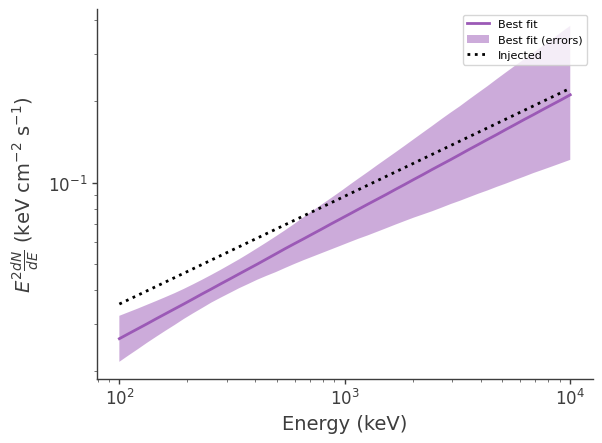

In [19]:
fig,ax = plt.subplots()

ax.plot(energy, energy*energy*flux_median, label = "Best fit")
ax.fill_between(energy, energy*energy*flux_lo, energy*energy*flux_hi, alpha = .5, label = "Best fit (errors)")
ax.plot(energy, energy*energy*flux_inj, color = 'black', ls = ":", label = "Injected")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel(r"$E^2 \frac{dN}{dE}$ (keV cm$^{-2}$ s$^{-1}$)")

ax.legend()
plt.show()
fig.savefig('./Spectral_fitting_4cp2135_noflare.png')
plt.close()

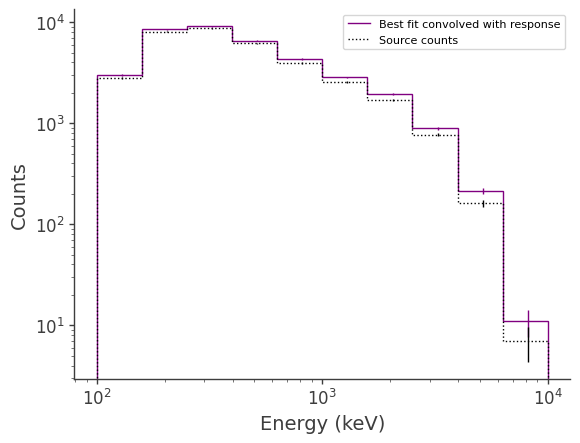

In [20]:
fig,ax = plt.subplots()

ax.stairs(expectation.project('Em').todense().contents, binned_energy_edges, color='purple', label = "Best fit convolved with response")
ax.errorbar(binned_energy, expectation.project('Em').todense().contents, yerr=np.sqrt(expectation.project('Em').todense().contents), color='purple', linewidth=0, elinewidth=1)
ax.stairs(blazar.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Source counts")
ax.errorbar(binned_energy, blazar.binned_data.project('Em').todense().contents, yerr=np.sqrt(blazar.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

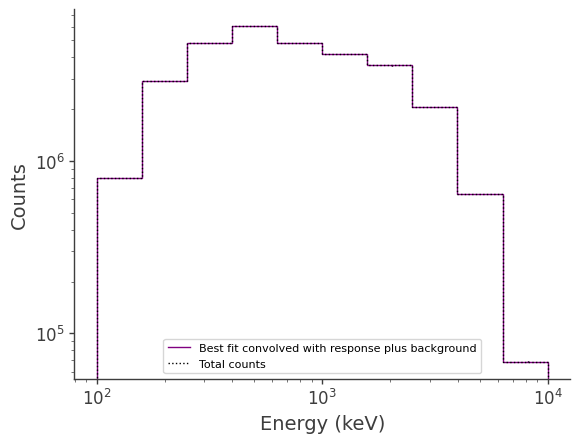

In [21]:
fig,ax = plt.subplots()

ax.stairs(expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents), binned_energy_edges, color='purple', label = "Best fit convolved with response plus background")
ax.errorbar(binned_energy, expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents), yerr=np.sqrt(expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents)), color='purple', linewidth=0, elinewidth=1)
ax.stairs(blazar_bkg.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Total counts")
ax.errorbar(binned_energy, blazar_bkg.binned_data.project('Em').todense().contents, yerr=np.sqrt(blazar_bkg.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

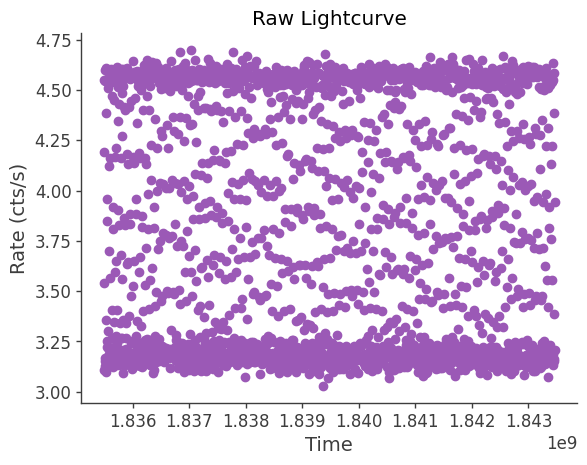

In [22]:
blazar_bkg.get_raw_lightcurve(binned_data="4C21p35_noflare_AlbedoPhoton_bkg_binned_data.hdf5", output_name="lc_noflare")
time, rate = np.loadtxt("lc_noflare.dat", skiprows=1, unpack=True)
plt.scatter(time, rate)
plt.xlabel('Time')
plt.ylabel('Rate (cts/s)')
plt.title('Raw Lightcurve')
plt.savefig('./Raw_lc_4cp2135_noflare.png', dpi=300)
plt.show()
plt.close()
plt.close()

Compute integral flux from the fitted spectrum

#### Method 1 from threeML without error propagation

In [23]:
simulated_flux = 0.0005535336768481181


In [24]:
# https://threeml.readthedocs.io/en/latest/notebooks/flux_examples.html
# Get the simulated flux from the below
# https://github.com/cositools/cosi-sim/blob/main/cosi_sim/Source_Library/DC2/sources/Galactic/Crab/Crab.source

threeML_config.point_source.integrate_flux_method = "quad" # trapz, quad
result_fl=results.get_flux(
        ene_min= 100. * u.keV,
        ene_max= 10000. * u.keV,
        confidence_level=0.95,
        sum_sources=True,
        flux_unit="1/(cm2 s)" # 1/(cm2 s) (for integral photon flux) and keV/(cm2 s) or erg/(cm2 s) (for integral photon flux)
    )
print(result_fl)
# fl.flux.apply(lambda x: float(str(x).split()[1])).values[0]

print('\nThe simulated flux is: '+str(simulated_flux)+'\n')
print('Flux from the fitted spectrum (quad) is: '+str(result_fl["flux"].values[0].value)+'')

processing MLE analyses:   0%|                            | 0/1 [00:00<?, ?it/s]

                                    flux                           low bound  \
total  0.0004479148457356326 1 / (s cm2)  0.00034742037015958016 1 / (s cm2)   

                                hi bound  
total  0.0005977689443592185 1 / (s cm2)  

The simulated flux is: 0.0005535336768481181

Flux from the fitted spectrum (quad) is: 0.0004479148457356326


In [25]:
# https://threeml.readthedocs.io/en/latest/notebooks/flux_examples.html
# Get the simulated flux from the below
# https://github.com/cositools/cosi-sim/blob/main/cosi_sim/Source_Library/DC2/sources/GRBs/GRB090206620/GRB090206620.source

threeML_config.point_source.integrate_flux_method = "trapz" # trapz, quad
result_fl=results.get_flux(
        ene_min= 100. * u.keV,
        ene_max= 10000. * u.keV,
        confidence_level=0.95,
        sum_sources=True,
        flux_unit="1/(cm2 s)" # 1/(cm2 s) (for integral photon flux) and keV/(cm2 s) or erg/(cm2 s) (for integral photon flux)
    )
print(result_fl)
# fl.flux.apply(lambda x: float(str(x).split()[1])).values[0]

print('\nThe simulated flux is: '+str(simulated_flux)+'\n')
print('Flux from the fitted spectrum (trapz) is: '+str(result_fl["flux"].values[0].value)+'')

processing MLE analyses:   0%|                            | 0/1 [00:00<?, ?it/s]

                                    flux                          low bound  \
total  0.0005566662587652858 1 / (s cm2)  0.0004423450400915581 1 / (s cm2)   

                                hi bound  
total  0.0007092645562937232 1 / (s cm2)  

The simulated flux is: 0.0005535336768481181

Flux from the fitted spectrum (trapz) is: 0.0005566662587652858


#### Method 2 Manual Methods

In [41]:
bin_energy_edges = np.geomspace(blazar_bkg.binned_data.axes['Em'].edges[0],blazar_bkg.binned_data.axes['Em'].edges[-1], 51).to_value(u.keV)

bin_energy = np.array([])
bin_energy_delta = np.array([])

for i in range(len(bin_energy_edges)-1):
    bin_energy = np.append(bin_energy, np.sqrt(bin_energy_edges[i+1]*bin_energy_edges[i]))
    bin_energy_delta = np.append(bin_energy_delta, bin_energy_edges[i+1]-bin_energy_edges[i])

photon_flux = 0
energy_flux = 0
        
for i, e in enumerate(bin_energy):
    photon_flux += results_err(e)*bin_energy_delta[i]
    energy_flux += results_err(e)*e*bin_energy_delta[i]

print('Photon Flux from the fitted spectrum is: '+str(photon_flux.median)+'')
print('Energy Flux from the fitted spectrum is: '+str(energy_flux.median)+'')

Photon Flux from the fitted spectrum is: 0.00044802117191363713
Energy Flux from the fitted spectrum is: 0.4101549582894599


In [42]:
bin_energy_edges = np.geomspace(blazar_bkg.binned_data.axes['Em'].edges[0],blazar_bkg.binned_data.axes['Em'].edges[-1], 51).to_value(u.keV)

bin_energy = np.array([])
bin_energy_delta = np.array([])

for i in range(len(bin_energy_edges)-1):
    bin_energy = np.append(bin_energy, np.sqrt(bin_energy_edges[i+1]*bin_energy_edges[i]))
    bin_energy_delta = np.append(bin_energy_delta, bin_energy_edges[i+1]-bin_energy_edges[i])

photon_flux = 0
energy_flux = 0
        
for i, e in enumerate(bin_energy):
    photon_flux += spectrum(e)*bin_energy_delta[i]
    energy_flux += spectrum(e)*e*bin_energy_delta[i]

print('Photon Flux from the fitted spectrum is: '+str(photon_flux)+'')
print('Energy Flux from the fitted spectrum is: '+str(energy_flux)+'')

Photon Flux from the fitted spectrum is: 0.0004438642741144177
Energy Flux from the fitted spectrum is: 0.4106518444547014


In [43]:
bin_energy_edges = np.geomspace(blazar_bkg.binned_data.axes['Em'].edges[0],blazar_bkg.binned_data.axes['Em'].edges[-1], 51).to_value(u.keV)

bin_energy = np.array([])
bin_energy_delta = np.array([])

for i in range(len(bin_energy_edges)-1):
    bin_energy = np.append(bin_energy, np.sqrt(bin_energy_edges[i+1]*bin_energy_edges[i]))
    bin_energy_delta = np.append(bin_energy_delta, bin_energy_edges[i+1]-bin_energy_edges[i])

photon_flux = 0
energy_flux = 0
        
for i, e in enumerate(bin_energy):
    photon_flux += spectrum_inj(e)*bin_energy_delta[i]
    energy_flux += spectrum_inj(e)*e*bin_energy_delta[i]

print('Photon Flux from the fitted spectrum is: '+str(photon_flux)+'')
print('Energy Flux from the fitted spectrum is: '+str(energy_flux)+'')

Photon Flux from the fitted spectrum is: 0.0005536588962166458
Energy Flux from the fitted spectrum is: 0.47068315728252164
